In [6]:
# !pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.0 MB/s eta 0:00:00


## Load libaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

from spacy.matcher import Matcher
# from google.colab import drive

## Load data

In [3]:
%%time

# Mount Google Drive
# drive.mount('/content/drive')

# Specify the path to the .feather file
# file_path = "/content/drive/MyDrive/diagnose_en_dataset.feather"
# file_path = "/content/drive/MyDrive/diagnose_en_dataset-patient_info-With_Gender_and_Reference.feather"
file_path = "diagnose_en_dataset-patient_info-With_Gender_and_Reference-response_Bias_measures.feather"

# file_path = "/content/drive/MyDrive/"

# Load the .feather file as a Pandas DataFrame
df = pd.read_feather(file_path)

# Print the DataFrame
df.head()

CPU times: user 598 ms, sys: 452 ms, total: 1.05 s
Wall time: 1.04 s


,id,Description,Doctor,Patient,Self,Gender,Gend_bias_freq,Response_len,Disagree_freq
0,0,Q. What does abutment of the nerve root mean?,Hi. I have gone through your query with dilige...,"Hi doctor,I am just wondering what is abutting...",1,X,0,35,0
1,1,"Q. Every time I eat spicy food, I poop blood. ...",Hello. I have gone through your information an...,"Hi doctor, I am a 26 year old male. I am 5 fee...",1,M,0,65,0
2,2,Q. Will Nano-Leo give permanent solution for e...,Hi. For further doubts consult a sexologist on...,"Hello doctor, I am 48 years old. I am experien...",1,M,0,13,0
3,3,Q. Will Kalarchikai cure multiple ovarian cyst...,Hello. I just read your query. See Kalarachi K...,"Hello doctor, I have multiple small cysts in b...",1,F,0,127,1
4,4,Q. I masturbate only by rubbing the tip of the...,Hi. For further doubts consult a sexologist on...,"Hi doctor, During masturbation I just rub the ...",1,M,0,21,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257469 entries, 0 to 257468
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              257469 non-null  int64 
 1   Description     257469 non-null  object
 2   Doctor          257469 non-null  object
 3   Patient         257469 non-null  object
 4   Self            257469 non-null  int64 
 5   Gender          257469 non-null  object
 6   Gend_bias_freq  257469 non-null  int64 
 7   Response_len    257469 non-null  int64 
 8   Disagree_freq   257469 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 17.7+ MB


In [6]:
# from transformers import pipeline

# classifier = pipeline("sentiment-analysis")
# classifier("I've been waiting for a HuggingFace course my whole life.")

In [7]:
# from transformers import GPT2Tokenizer, GPT2LMHeadModel


In [8]:
# # Load pre-trained model and tokenizer
# model_name = "gpt2"
# tokenizer = GPT2Tokenizer.from_pretrained(model_name)
# model = GPT2LMHeadModel.from_pretrained(model_name)

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
model_name = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [11]:
count = 0

def doctors_stance(premise):
  global count
  count += 1

  hypothesis = "The health concerns are valid."
  input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
  output = model(input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
  prediction = torch.softmax(output["logits"][0], -1).tolist()
  label_names = ["entailment", "neutral", "contradiction"]
  prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}

  if count % 1000 == 0:
    print(f'No. of entries processed: {count}')

  return prediction['entailment'], prediction['neutral'], prediction['contradiction']

In [12]:
# n_sample = 200
# df_small = df.sample(n = n_sample)

df_small = df

df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257469 entries, 0 to 257468
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              257469 non-null  int64 
 1   Description     257469 non-null  object
 2   Doctor          257469 non-null  object
 3   Patient         257469 non-null  object
 4   Self            257469 non-null  int64 
 5   Gender          257469 non-null  object
 6   Gend_bias_freq  257469 non-null  int64 
 7   Response_len    257469 non-null  int64 
 8   Disagree_freq   257469 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 17.7+ MB


## Apply function: *`doctors_stance`*

In [15]:
# %%time
# # Check the length of doctor's response (in no. of words) and frequency of disagreement keywords
# df_small[['entailment','neutral', 'contradiction']] = df_small['Doctor'].apply(lambda x: pd.Series(doctors_stance(x)))

In [13]:
%%time

# Define the size of each smaller DataFrame
chunk_size = 10000
# chunk_size = 10

# Iterate over the chunks of the DataFrame
for i in range(0, len(df_small), chunk_size):
    chunk = df_small[i:i+chunk_size]

    # Apply your function on the current chunk
    chunk[['entailment','neutral', 'contradiction']] = chunk['Doctor'].apply(lambda x: pd.Series(doctors_stance(x)))

    output_path = "Stance-files/AA-diagnose_en_dataset-Stance-"+ str(i) + ".csv"
    print(f'No. of entries processed: {i}')

    # # Save the DataFrame as a .feather file
    # df_small.to_feather(output_path)
    chunk.to_csv(output_path)


No. of entries processed: 1000
No. of entries processed: 2000
No. of entries processed: 3000
No. of entries processed: 4000
No. of entries processed: 5000
No. of entries processed: 6000
No. of entries processed: 7000
No. of entries processed: 8000
No. of entries processed: 9000
No. of entries processed: 10000


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


No. of entries processed: 0
No. of entries processed: 11000
No. of entries processed: 12000
No. of entries processed: 13000
No. of entries processed: 14000
No. of entries processed: 15000
No. of entries processed: 16000
No. of entries processed: 17000
No. of entries processed: 18000
No. of entries processed: 19000
No. of entries processed: 20000
No. of entries processed: 10000
No. of entries processed: 21000
No. of entries processed: 22000


KeyboardInterrupt: 

In [31]:

range(0, len(df_small), chunk_size)

range(0, 200, 10)

In [ ]:
# df_small_v1_200 = df_small
# df_small_v1_200.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 217523 to 199845
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2000 non-null   int64 
 1   Description     2000 non-null   object
 2   Doctor          2000 non-null   object
 3   Patient         2000 non-null   object
 4   Self            2000 non-null   int64 
 5   Gender          2000 non-null   object
 6   Gend_bias_freq  2000 non-null   int64 
 7   Response_len    2000 non-null   int64 
 8   Disagree_freq   2000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 156.2+ KB


In [23]:
# 104 * (257469 / 2000) / (60 * 24)

9.297491666666666

In [19]:
df_small.head()

,id,Description,Doctor,Patient,Self,Gender,Gend_bias_freq,Response_len,Disagree_freq,entailment,neutral,contradiction
149965,149965,Platelet count abnormal. Had blood test. Takin...,"Hello and welcome to HCM,MRSA is a very resist...",iacuired MRSA in 2005-2007 during an outpatien...,1,X,0,156,0,54.4,45.4,0.2
131275,131275,Does crab meat cause allergic reaction?,"HI, thanks for using healthcare magicIt is pos...",I have a red spot on my left knee that at firs...,1,X,0,87,2,96.5,3.4,0.1
118999,118999,What causes burning sensation in lower left ab...,"In regard to this present status, the best and...",I had an episode of severe upper abdominal pai...,1,X,0,22,0,0.2,99.7,0.0
96055,96055,How to cure a big lump on the left leg?,Hi.Read and understood the history about your ...,"sir,my father's age is 64 years and his weight...",0,M,0,148,1,47.3,52.6,0.1
127950,127950,Should the hand burn with blisters be left unc...,Hi Thanks for posting your query on Health Car...,I was playing basketball the other night and w...,1,M,0,111,0,0.1,99.9,0.0


In [20]:
df_small.groupby('Gender')['entailment', 'neutral', 'contradiction'].mean()

<ipython-input-20-a1b824881862>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_small.groupby('Gender')['entailment', 'neutral', 'contradiction'].mean()


,entailment,neutral,contradiction
Gender,,,
F,26.953913,70.247826,2.784522
M,22.297852,75.563962,2.125537
X,24.131909,73.786879,2.068588


<br>
<br>
<br>
<br>


<ipython-input-64-1214a00bb520>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_small.groupby('Gender')['entailment', 'neutral', 'contradiction'].mean().plot(kind='barh')


<Axes: ylabel='Gender'>

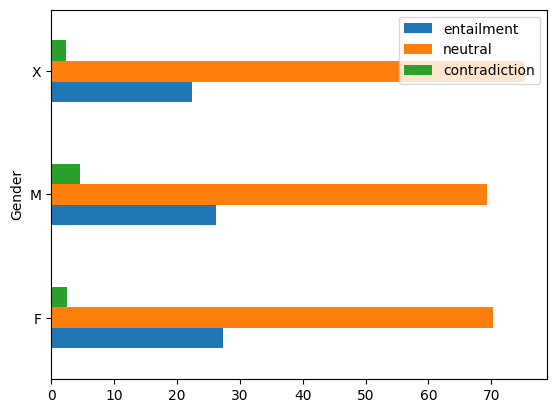

In [ ]:
df_small.groupby('Gender')['entailment', 'neutral', 'contradiction'].mean().plot(kind='barh')

## Save the data frame

In [24]:
# # Specify the path to save the .feather file
# output_path = "/content/drive/MyDrive/diagnose_en_dataset-patient_info-With_Gender_and_Reference-response_Bias_measures.feather"
# output_path = "/content/drive/MyDrive/diagnose_en_dataset-patient_info-With_Gender_and_Reference-Stance-2k_random-set2.csv"
output_path = "/content/drive/MyDrive/diagnose_en_dataset-patient_info-With_Gender_and_Reference-Stance.csv"

# # Save the DataFrame as a .feather file
# df_small.to_feather(output_path)
df_small.to_csv(output_path)

In [15]:
df.shape

(257469, 9)